Import necessary modules

In [29]:
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

Create data for learing

In [22]:
if torch.cuda.is_available():
    device = torch.device ("cuda")
else:
    device = torch.device ("cpu")

alpha = 0.01
epochs = 100000

print (f"Default devise: {device}")

def create_data ():

    x_colloc = torch.rand(10000, 1, requires_grad=True).to(device)
    t_colloc = torch.rand(10000, 1, requires_grad=True).to(device)

    x_boundary = torch.cat([torch.zeros(5000, 1), torch.ones(5000, 1)], dim=0).to(device)
    t_boundary = torch.rand(10000, 1).to(device)

    x_initial = torch.rand(10000, 1).to(device)
    t_initial = torch.zeros(10000, 1).to(device)

    return x_colloc, t_colloc, x_boundary, t_boundary, x_initial, t_initial

x_rod, t_rod, x_bd, t_bd, x_init, t_init = create_data ()



Default devise: cuda


Check education points

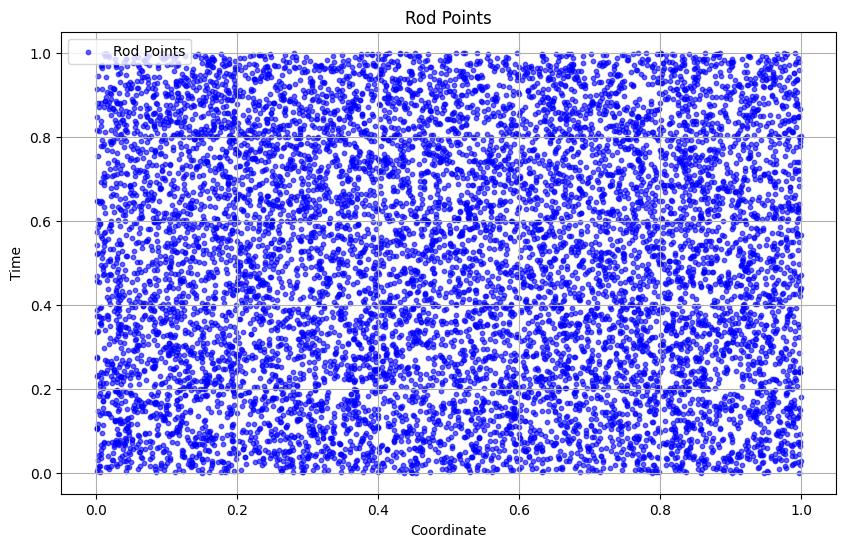

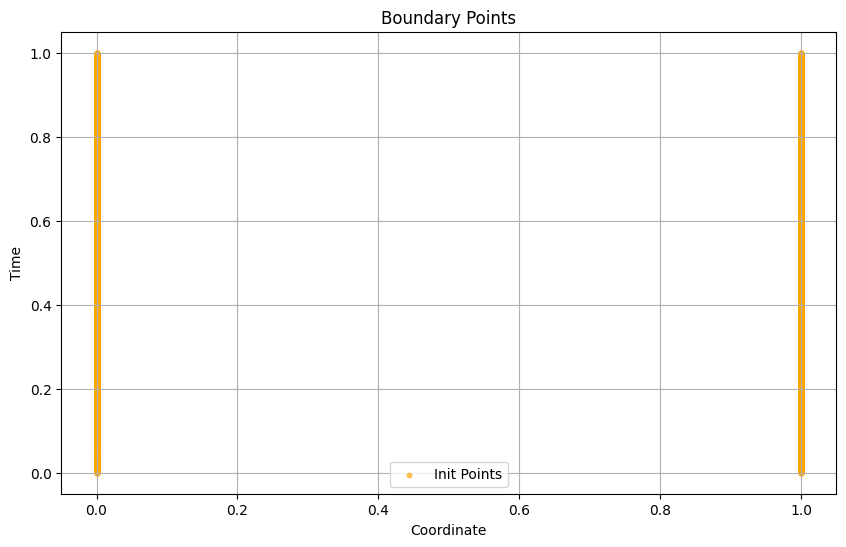

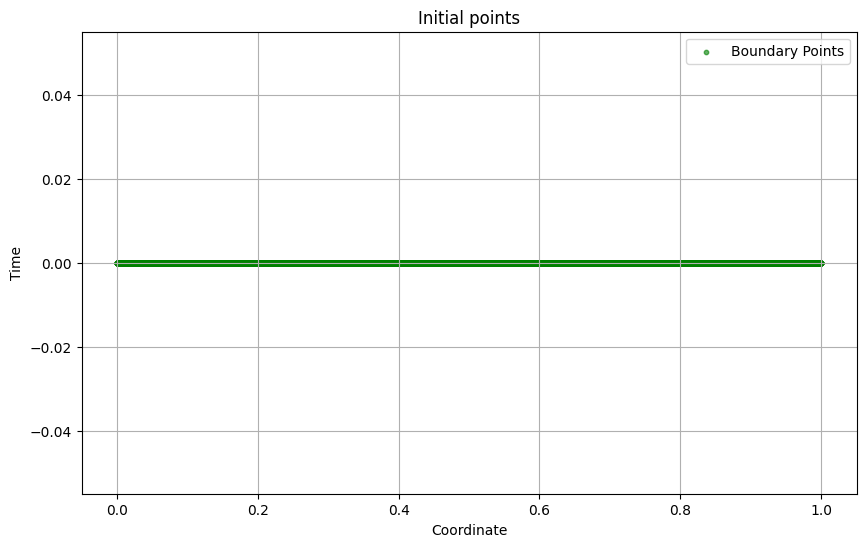

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(x_rod.cpu().detach().numpy(), t_rod.cpu().detach().numpy(), c='blue', s=10, alpha=0.6, label='Rod Points')
plt.title("Rod Points")
plt.xlabel("Coordinate")
plt.ylabel("Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(x_bd.cpu().detach().numpy(), t_bd.cpu().detach().numpy(), c='orange', s=10, alpha=0.6, label='Init Points')
plt.title(f"Boundary Points")
plt.xlabel("Coordinate")
plt.ylabel("Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(x_init.cpu(), t_init.cpu(), c='green', s=10, alpha=0.6, label='Boundary Points')
plt.title(f"Initial points")
plt.xlabel("Coordinate")
plt.ylabel("Time")
plt.grid(True)
plt.legend()
plt.show()

Initializate model

In [24]:
def init_weight(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

In [25]:
class PINN (nn.Module):
    def __init__ (self, n_hidden, n_neurons, activation, verbose = True):
        super().__init__ ()
        self.model = nn.Sequential ()
        self.build_NN (n_hidden, n_neurons, activation)
        self.model.to(device)


        if verbose:
            print (self.model)

        self.model.apply (init_weight)


    def build_NN (self,n_hidden, n_neurons, activation):
        self.model.add_module ('input layer',nn.Linear (2, n_neurons))
        self.model.add_module ('activation func', activation)
        
        for _ in range (n_hidden-1):
            self.model.add_module (f'hidden layer number: {_}', nn.Linear (n_neurons, n_neurons))
            self.model.add_module (f'activation func {_}', activation)

        self.model.add_module ('Output layer',nn.Linear (n_neurons, 1))

    def forward (self, x, t):
        x = torch.concat ([x,t], dim=1).to(device)
        out = self.model (x)
        return out
    

def pde_loss(model, x, t):
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, create_graph=True, grad_outputs=torch.ones_like(t_rod))[0]
    u_x = torch.autograd.grad(u, x, create_graph=True, grad_outputs=torch.ones_like(x_rod))[0]
    u_xx = torch.autograd.grad(u_x, x, create_graph=True, grad_outputs=torch.ones_like(x_rod))[0]
    
    physics_loss = u_t - (alpha)*u_xx 
    physics_loss = torch.mean(physics_loss**2)
    return physics_loss

def boundary_loss(model, x, t):

    u = model(x, t)
    loss = torch.mean(torch.square(u))
    return loss

def initial_loss(model, x, t):

    u = model(x, t)
    correct_vals = torch.sin(math.pi * x)
    loss = torch.mean((correct_vals - u)**2)
    return loss

Training model

In [26]:
model = PINN(5, 25, nn.Tanh())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
total_loss_graph = []

for epoch in range(epochs):
    optimizer.zero_grad()
    eq_loss = pde_loss(model, x_rod, t_rod)
    bc_loss = boundary_loss(model, x_bd, t_bd)
    init_loss = initial_loss(model, x_init, t_init)

    total_loss = eq_loss + bc_loss + init_loss
    total_loss.backward()
    optimizer.step()
    if epoch%100 == 0:
        print(f"epoch: {epoch}, loss: {total_loss.item()}")
        total_loss_graph.append (total_loss.item())

Sequential(
  (input layer): Linear(in_features=2, out_features=25, bias=True)
  (activation func): Tanh()
  (hidden layer number: 0): Linear(in_features=25, out_features=25, bias=True)
  (activation func 0): Tanh()
  (hidden layer number: 1): Linear(in_features=25, out_features=25, bias=True)
  (activation func 1): Tanh()
  (hidden layer number: 2): Linear(in_features=25, out_features=25, bias=True)
  (activation func 2): Tanh()
  (hidden layer number: 3): Linear(in_features=25, out_features=25, bias=True)
  (activation func 3): Tanh()
  (Output layer): Linear(in_features=25, out_features=1, bias=True)
)
epoch: 0, loss: 0.6395869255065918
epoch: 100, loss: 0.5465818047523499
epoch: 200, loss: 0.47341495752334595
epoch: 300, loss: 0.41593679785728455
epoch: 400, loss: 0.37192320823669434
epoch: 500, loss: 0.33979177474975586
epoch: 600, loss: 0.31783196330070496
epoch: 700, loss: 0.3038533627986908
epoch: 800, loss: 0.2953902781009674
epoch: 900, loss: 0.2901982069015503
epoch: 1000, l

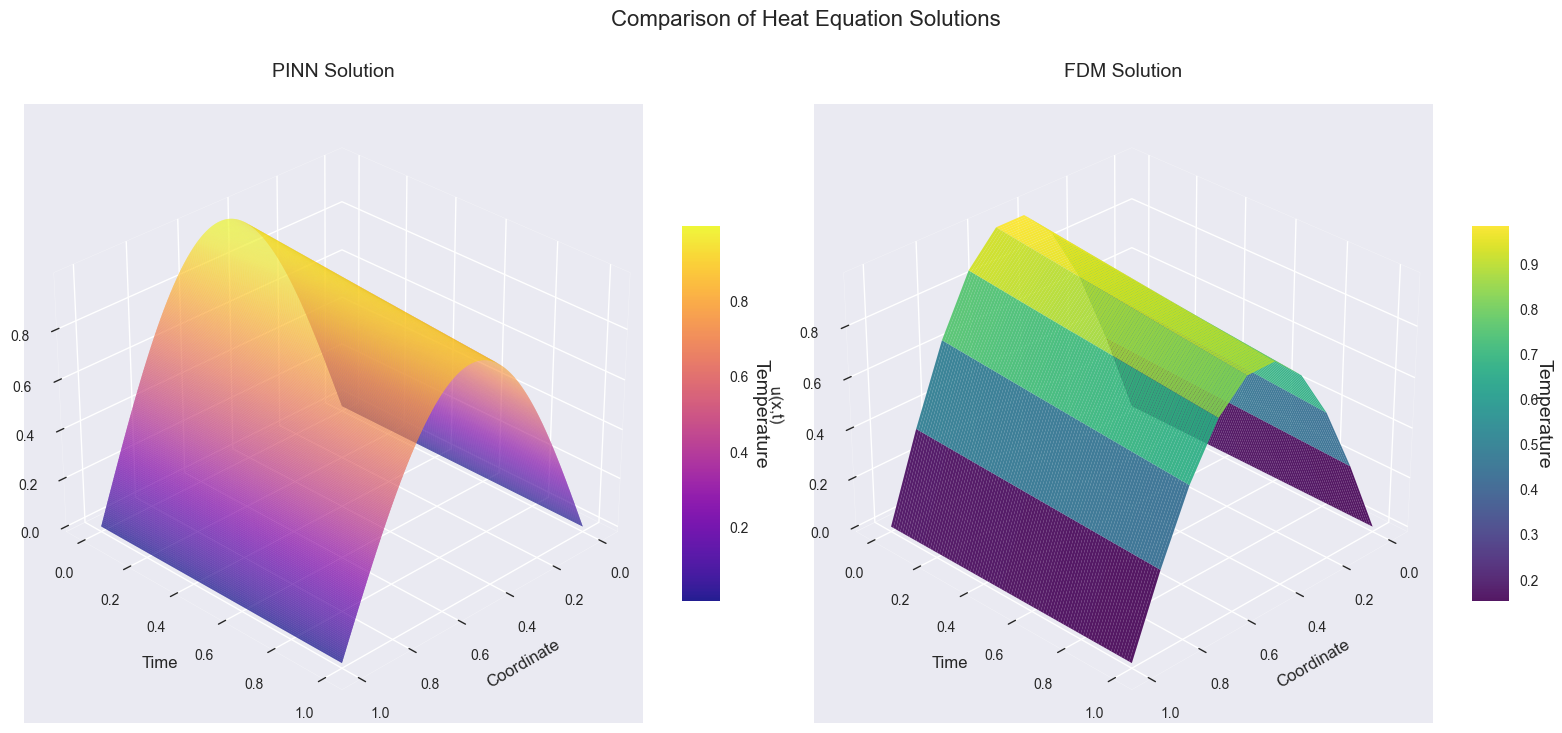

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib import cm


x_plot = torch.linspace(0, 1, 500).view(-1, 1)
t_plot = torch.linspace(0, 1, 500).view(-1, 1)
X_plot, T_plot = torch.meshgrid(x_plot.view(-1), t_plot.view(-1))

x_flat = X_plot.flatten().view(-1, 1)
t_flat = T_plot.flatten().view(-1, 1)

u_pred = model(x_flat, t_flat).cpu().detach().numpy()
U_plot = u_pred.reshape(500, 500)


fig = plt.figure(figsize=(16, 7), facecolor='white')  


ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X_plot.numpy(), T_plot.numpy(), U_plot, 
                        cmap='plasma',  
                        edgecolor='none', 
                        antialiased=True,
                        rstride=1, cstride=1,  
                        alpha=0.9)

ax1.set_xlabel('Coordinate', fontsize=12, labelpad=10)
ax1.set_ylabel('Time', fontsize=12, labelpad=10)
ax1.set_zlabel('u(x,t)', fontsize=12, labelpad=10)
ax1.set_title('PINN Solution', fontsize=14, pad=20)
ax1.xaxis.pane.fill = False  
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
ax1.xaxis.pane.set_edgecolor('w')  
ax1.yaxis.pane.set_edgecolor('w')
ax1.zaxis.pane.set_edgecolor('w')
ax1.grid(True, linestyle=':', alpha=0.5)
ax1.view_init(elev=30, azim=45)  


cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.6, aspect=10)
cbar1.set_label('Temperature', rotation=270, labelpad=15)


ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, T, fdm_solution, 
                        cmap='plasma',  
                        edgecolor='none',
                        antialiased=True,
                        rstride=1, cstride=1,
                        alpha=0.9)

ax2.set_xlabel('Coordinate', fontsize=12, labelpad=10)
ax2.set_ylabel('Time', fontsize=12, labelpad=10)
ax2.set_zlabel('u(x,t)', fontsize=12, labelpad=10)
ax2.set_title('FDM Solution', fontsize=14, pad=20)
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False
ax2.xaxis.pane.set_edgecolor('w')
ax2.yaxis.pane.set_edgecolor('w')
ax2.zaxis.pane.set_edgecolor('w')
ax2.grid(True, linestyle=':', alpha=0.5)
ax2.view_init(elev=30, azim=45)


cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.6, aspect=10)
cbar2.set_label('Temperature', rotation=270, labelpad=10)


plt.suptitle('Comparison of Heat Equation Solutions', fontsize=16, y=1.05)


plt.tight_layout()

plt.show()

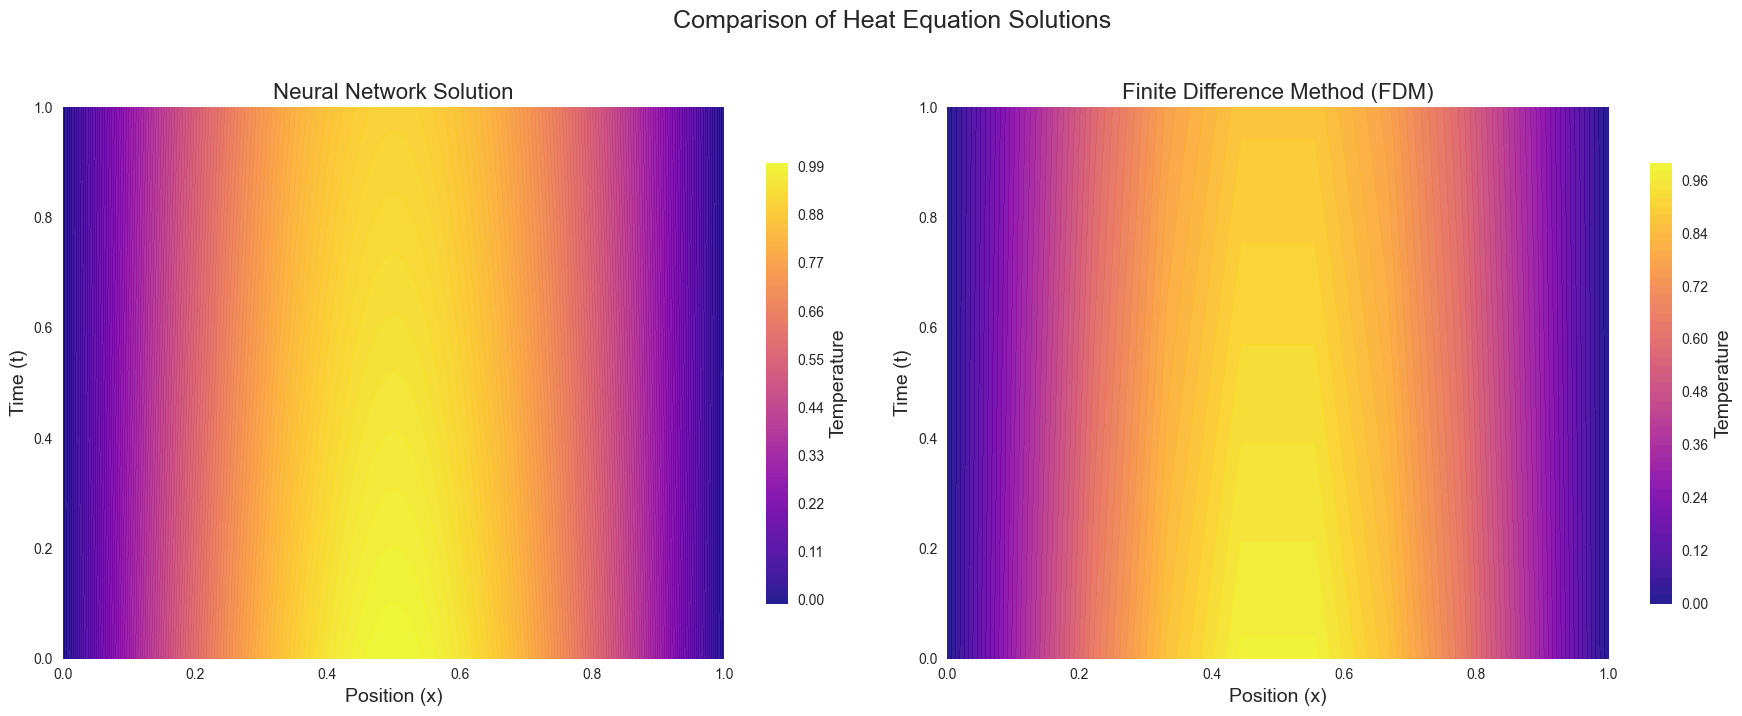

In [77]:

x_plot_1d = x_plot.flatten().numpy() 
t_plot_1d = t_plot.flatten().numpy()  
U_plot_2d = U_plot.T  


plt.style.use('seaborn-v0_8')  
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))


contour1 = ax1.contourf(
    x_plot_1d, 
    t_plot_1d, 
    U_plot_2d, 
    levels=100, 
    cmap='plasma', 
    alpha=0.9
)
fig.colorbar(contour1, ax=ax1, label='Temperature', shrink=0.8)
ax1.set_title('Neural Network Solution')
ax1.set_xlabel('Position (x)')
ax1.set_ylabel('Time (t)')
ax1.set_ylim(0, 1)
ax1.grid(True, linestyle=':', alpha=0.5)


contour2 = ax2.contourf(
    X,  
    T, 
    fdm_solution, 
    levels=50, 
    cmap='plasma', 
    alpha=0.9
)
fig.colorbar(contour2, ax=ax2, label='Temperature', shrink=0.8)
ax2.set_title('Finite Difference Method (FDM)')
ax2.set_xlabel('Position (x)')
ax2.set_ylabel('Time (t)')
ax2.grid(True, linestyle=':', alpha=0.5)

plt.suptitle('Comparison of Heat Equation Solutions', y=1.02, fontsize=18)
plt.tight_layout()
plt.show()